# Data Prep

This notebook details the steps taken to process the raw data into the train and test data that was used for the competition.

In [64]:
import os
import numpy
import pandas as pd
import mne
import scipy.stats as stats
import matplotlib.pyplot as plt

## Examining the Raw Data

### Data Files

In [2]:
raw_path = '/workspace/Competition/PSG/data/raw'
raw_files = os.listdir(raw_path)

In [3]:
print(len(raw_files))

40


In [4]:
raw_files[0:10]

['10_22339.edf',
 '10_22339.tsv',
 '16_24241.edf',
 '16_24241.tsv',
 '1_4789.edf',
 '1_4789.tsv',
 '22_23233.edf',
 '22_23233.tsv',
 '25_10579.edf',
 '25_10579.tsv']

We have 2 different types of data files:
* tsv files
* edf files

In [8]:
tsv_files = [x for x in raw_files if x.endswith('.tsv')]
edf_files = [x for x in raw_files if x.endswith('.edf')]

len(tsv_files), len(edf_files)

(20, 20)

There are 20 of each.

In [9]:
# Sort the two lists
tsv_files.sort()
edf_files.sort()

# Check if the names of the files match
sum([x.split('.')[0] == y.split('.')[0] for x,y in zip(tsv_files, edf_files)])

20

We can see that there is a corresponding edf file for each tsv file.

### tsv files

In [12]:
data = pd.read_csv(os.path.join(raw_path, tsv_files[0]), delimiter='\t')

data.head(10)

,onset,duration,description
0,0.496094,0.0,Start Recording
1,0.496094,0.0,"Montage:NCH_PSG_STANDARD, Ref"
2,0.496094,0.0,"Montage:NCH_PSG_STANDARD, Ref"
3,0.687500,0.0,Recording Analyzer - ECG
4,1.023438,0.0,Video Recording ON
5,32.007812,0.0,Montage:Channel Test Referential
6,32.007812,0.0,Montage:Channel Test Referential
7,91.832031,0.0,Montage:NCH_PSG_STANDARD
8,91.832031,0.0,Montage:NCH_PSG_STANDARD
9,3094.042969,0.0,Impedance at 10 kOhm


As we can see, there are 3 columns to a tsv file:
* onset: The time point at which a specific event begins.
* duration: The duration of that given event.
* description: The type of event that occurs.

In [17]:
data['description'].unique()

array(['Start Recording', 'Montage:NCH_PSG_STANDARD, Ref',
       'Recording Analyzer - ECG', 'Video Recording ON',
       'Montage:Channel Test Referential', 'Montage:NCH_PSG_STANDARD',
       'Impedance at 10 kOhm', 'Body Position: Supine',
       'bed flat for biocals eyes open', 'eyes closed', 'eyes open',
       'eyes closed up and down', 'eyes closed left and right', 'blinks',
       'chew', 'loud snores', 'nasal breathing', 'oral breathing',
       'breath hold', 'left foot flex', 'right foot flex', 'biocals done',
       'bed flat controls locked one pillow in use', 'Sleep stage W',
       'Lights Off', 'Started Analyzer - ECG',
       'Started Analyzer - Data Trends',
       'Started Analyzer - Sleep Events', 'Body Position: Left',
       'Oxygen Desaturation',
       'pt has pushed pillow totally out from under her head',
       'sleep onset soft snores', 'Sleep stage N1', 'Sleep stage N2',
       'jerk', 'soft snores', 'Sleep stage N3', 'EEG arousal', 'move',
       'threw c

In [19]:
data['description'].value_counts()

Sleep stage N2                                          439
Sleep stage N3                                          196
Sleep stage R                                           157
Sleep stage W                                           119
Sleep stage ?                                            68
                                                       ... 
Started Analyzer - ECG                                    1
Started Analyzer - Data Trends                            1
Started Analyzer - Sleep Events                           1
pt has pushed pillow totally out from under her head      1
sleep onset soft snores                                   1
Name: description, Length: 63, dtype: int64

As we can see, there are various types of events that have been labelled. Of those events, those important to us are:
* Sleep stage N1
* Sleep stage N2
* Sleep stage N3
* Sleep stage R
* Sleep stage W

We compile information about the sleep stages from all of the tsv files.

In [47]:
sleep_stages = []
stage_durations = []
stage_onsets = []
recs = []
inds = []
isend = []

for rec in tsv_files:
    recpath = os.path.join(raw_path, rec)
    data = pd.read_csv(recpath, delimiter='\t')
    descriptions = list(data['description'])
    durations = list(data['duration'])
    onsets = list(data['onset'])
    for i in range(len(data)):
        if 'Sleep stage' in descriptions[i]:
            sleep_stages.append(descriptions[i])
            stage_durations.append(durations[i])
            stage_onsets.append(onsets[i])
            recs.append(rec)
            inds.append(i)
            if i == len(data)-1:
                isend.append(True)
            else:
                isend.append(False)

compiled_df = pd.DataFrame({'stage':sleep_stages,'dur':stage_durations,'onset':stage_onsets,'rec':recs, 'ind':inds, 'end':isend})

In [48]:
compiled_df.head()

,stage,dur,onset,rec,ind,end
0,Sleep stage W,30.0,10530.460938,10_22339.tsv,30,False
1,Sleep stage W,30.0,10560.460938,10_22339.tsv,35,False
2,Sleep stage W,30.0,10590.460938,10_22339.tsv,37,False
3,Sleep stage W,30.0,10620.460938,10_22339.tsv,38,False
4,Sleep stage W,30.0,10650.460938,10_22339.tsv,39,False


We first check to see the durations of the sleep stage events.

In [49]:
compiled_df['dur'].value_counts()

30.000000    20901
17.539062        1
3.019531         1
27.675781        1
11.445312        1
20.000000        1
5.335938         1
23.359375        1
29.074219        1
27.300781        1
19.253906        1
23.683594        1
17.425781        1
19.351562        1
9.324219         1
23.597656        1
13.238281        1
25.738281        1
17.132812        1
21.160156        1
Name: dur, dtype: int64

In [51]:
shortdf = compiled_df[compiled_df.dur!=30].reset_index(drop=True)
shortdf

,stage,dur,onset,rec,ind,end
0,Sleep stage ?,17.539062,40530.460938,10_22339.tsv,1222,True
1,Sleep stage ?,17.132812,36270.867188,16_24241.tsv,1158,True
2,Sleep stage ?,25.738281,34650.261719,1_4789.tsv,1134,True
3,Sleep stage ?,13.238281,42330.761719,22_23233.tsv,1162,True
4,Sleep stage ?,23.597656,37500.402344,25_10579.tsv,1376,True
5,Sleep stage ?,9.324219,46350.675781,25_18085.tsv,1564,True
6,Sleep stage ?,19.351562,38460.648438,28_15280.tsv,1152,True
7,Sleep stage ?,17.425781,40350.574219,31_4429.tsv,1248,True
8,Sleep stage ?,23.683594,35820.316406,37_14779.tsv,1193,True
9,Sleep stage ?,19.253906,40620.746094,40_14503.tsv,1238,True


* There are a total of 19 instances for which the duration of a sleep event is not 30 seconds.
* Of those 19, 17 are because the recroding ended before a full 30 seconds.
* All the stages are unidentified ('Sleep stage ?')

We keep these in mind and move on to the edf files.

## EDF files

EDF stands for 'European Data Format'. It is commonly used to store biosignals. More information can be found [here](https://www.edfplus.info/). The raw signals of the PSG recordings are stored in EDF format and we use the [MNE library](https://mne.tools/stable/index.html) to handle them.

#### General Info

We test with 1 recording and see what kind of information and signals are included.

In [53]:
edfpath = os.path.join(raw_path, edf_files[0])
rawedf = mne.io.read_raw_edf(edfpath)

Extracting EDF parameters from /workspace/Competition/PSG/data/raw/10_22339.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [54]:
rawedf.info

<Info | 7 non-empty values
 bads: []
 ch_names: Patient Event, EOG LOC-M2, EOG ROC-M1, EMG Chin1-Chin2, EEG ...
 chs: 26 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2001-01-01 18:42:23 UTC
 nchan: 26
 projs: []
 sfreq: 256.0 Hz
>

In [57]:
len(rawedf.ch_names)

26

* We can see that there are 26 channels.
* The signals are sampled at 256Hz.

In [59]:
rawedf.ch_names

['Patient Event',
 'EOG LOC-M2',
 'EOG ROC-M1',
 'EMG Chin1-Chin2',
 'EEG F3-M2',
 'EEG F4-M1',
 'EEG C3-M2',
 'EEG C4-M1',
 'EEG O1-M2',
 'EEG O2-M1',
 'EEG CZ-O1',
 'EMG LLeg-RLeg',
 'ECG EKG2-EKG',
 'Snore',
 'Resp PTAF',
 'Resp Airflow',
 'Resp Thoracic',
 'Resp Abdominal',
 'SpO2',
 'Rate',
 'EtCO2',
 'Capno',
 'Resp Rate',
 'C-flow',
 'Tidal Vol',
 'Pressure']

#### Example Signal

We visualize one of the EEG signals.

In [62]:
signal = rawedf['EEG F3-M2']
signal

(array([[-1.05955596e-03,  9.89730678e-04,  1.38841840e-03, ...,
         -3.05180438e-08, -3.05180438e-08, -3.05180438e-08]]),
 array([0.00000000e+00, 3.90625000e-03, 7.81250000e-03, ...,
        4.05479883e+04, 4.05479922e+04, 4.05479961e+04]))

Each channel consists of 2 arrays. The first array is the actual signal and the second array corresponds to the time point at which the signal was sampled.

In [63]:
%matplotlib inline

Text(0, 0.5, 'EEG Voltage')

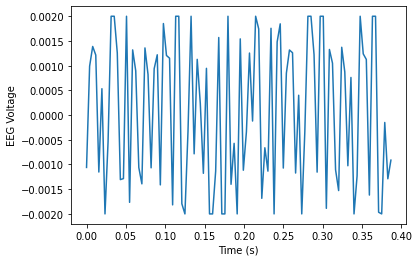

In [70]:
# First 100 samples from the signal
xs = signal[1][0:100]
ys = signal[0][0][0:100]

plt.figure()
plt.plot(xs, ys)
plt.xlabel('Time (s)')
plt.ylabel('EEG Voltage')


## Extracting signals from the EDF files

While there are many channels we can use, for this competition, we use the channel 'EEG F3-M2'. The diagram below shows where on the scalp this signal is recorded.

We first extract the channel 'EEG F3-M2' from each of the edf files and save them as .npy files. The following script does just that.

```
make_npy.py
```
This script takes 3 arguments:
* *input_dir*: Path to directory containing the raw edf files.
* *output_dir*: Path to directory to store the npy files.
* *channel*: The channel to use. Defaults to 'EEG F3-M2'

## 